In [130]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib.dates import DateFormatter

#### Climate data

Collect rolling window averages of various weather values 

In [386]:
def get_time_window(wvht, star_id, time_delta, include_after=False):
    df = wvht.copy().loc[star_id]
    df['Stranding_Date'] = pd.to_datetime(df['Stranding_Date'])
    df['Validity_Date'] =  pd.to_datetime(df['Validity_Date'])
    df['Time_Delta'] = (df['Stranding_Date'] - df['Validity_Date'])
    before = df.where((df['Time_Delta'] > pd.Timedelta(0)) & (df['Time_Delta'] < pd.Timedelta(90, 'h'))).dropna()
    before['Time_Delta'] = before['Time_Delta']/pd.Timedelta(hours=1)
    if include_after:
        after = df[(df['Time_Delta'] < pd.Timedelta(0)) & (df['Time_Delta'] > pd.Timedelta(90, 'h'))]
        before = pd.concat([before,after])
    return before

In [2]:
def get_historical_average(df, time_lag):
    df = df[df['Time_Delta'] < time_lag]
    df = df.groupby('STAR_ID').mean()
    return df

def get_stranding_frequency(time_lag):
    wvht = pd.read_csv('/Users/christopherberglund/Projects/stranding/90_hour_windows.csv')
    df = get_historical_average(wvht, time_lag)
    strandings = pd.read_csv('/Users/christopherberglund/Projects/stranding/local_stranding_waveheights.csv', float_precision='high')   
    strandings['Validity_Date'] = pd.to_datetime(strandings['Validity_Date'])
    averages = strandings.groupby('STAR_ID')[['Validity_Date','Value']].rolling(str(time_lag)+'h', on='Validity_Date').mean()
    averages['Value'] = averages['Value'].round(1)
    freq = averages.groupby(['STAR_ID', 'Value']).count()
    freq['Validity_Date'] = 1/freq['Validity_Date']
    freq = freq.rename(columns={'Validity_Date': 'Frequency'})

    df['Value'] = df['Value'].round(1)
    df = df.set_index('Value', append=True)
    freq = pd.merge(left=df, right=freq, left_index=True, right_index=True)
    freq = freq.reset_index().groupby('Value').agg('sum').reset_index()
    return freq

In [84]:
def get_window_averages(time_lag):
    df = pd.read_csv('/Users/christopherberglund/Projects/stranding/ndfd_local_data.csv', float_precision='high')
    df['Validity_Date'] = pd.to_datetime(df['Validity_Date'])
    df = df.set_index(['Latitude', 'Longitude', 'STAR_ID']).sort_values('Validity_Date')
    averages = (df[['Validity_Date','Wave_Height', 'Wind_Speed', 'Wind_Direction', 'Prcp']].rolling(str(time_lag)+'h', on='Validity_Date')
                .mean()
                .reset_index())
    averages['Validity_Date'] = averages['Validity_Date'] + pd.Timedelta(str(time_lag) + 'h')
    averages[['Wave_Height', 'Wind_Speed', 'Wind_Direction', 'Prcp']] = averages[['Wave_Height', 'Wind_Speed', 'Wind_Direction', 'Prcp']].round(1)

    averages = averages[averages['Validity_Date'].dt.month.isin([1,2,3,4])]
    
    wvht_freq = (averages.groupby(['Latitude', 'Longitude', 'Wave_Height'])
            .count()
            .rename(columns={'Validity_Date': 'WVHT_Frequency'})
            .reset_index())
    
    
    wdspd_freq = (averages.groupby(['Latitude', 'Longitude', 'Wind_Speed'])
            .count()
            .rename(columns={'Validity_Date': 'WDSPD_Frequency'})
            .reset_index())
    
    prcp_freq = (averages.groupby(['Latitude', 'Longitude', 'Prcp'])
            .count()
            .rename(columns={'Validity_Date': 'Prcp_Frequency'})
            .reset_index())

    averages = (pd.merge(left=averages, right=wvht_freq[['Latitude', 'Longitude', 'Wave_Height','WVHT_Frequency']], on=['Latitude', 'Longitude', 'Wave_Height'])
                .sort_values('Validity_Date'))
    
    averages = (pd.merge(left=averages, right=wdspd_freq[['Latitude', 'Longitude', 'Wind_Speed','WDSPD_Frequency']], on=['Latitude', 'Longitude', 'Wind_Speed'])
                .sort_values('Validity_Date'))
    
    averages = (pd.merge(left=averages, right=prcp_freq[['Latitude', 'Longitude', 'Prcp','Prcp_Frequency']], on=['Latitude', 'Longitude', 'Prcp'])
                .sort_values('Validity_Date'))
    
    return averages

def get_ano_nuevo_window(time_lag):
    df = pd.read_csv('/Users/christopherberglund/Projects/stranding/ndfd_ano_nuevo_data.csv', float_precision='high')
    df['Validity_Date'] = pd.to_datetime(df['Validity_Date'])
    averages = (df[['Validity_Date','Wave_Height', 'Wind_Speed', 'Wind_Direction', 'Prcp']].rolling(str(time_lag)+'h', on='Validity_Date')
                .mean()
                .reset_index())
    averages['Validity_Date'] = averages['Validity_Date'] + pd.Timedelta(str(time_lag) + 'h')
    averages[['Wave_Height', 'Wind_Speed', 'Wind_Direction', 'Prcp']] = averages[['Wave_Height', 'Wind_Speed', 'Wind_Direction', 'Prcp']].round(1)
    
    wvht_freq = (averages.groupby(['Wave_Height'])
            .count()
            .rename(columns={'Validity_Date': 'AN_WVHT_Frequency'})
            .reset_index())
    
    
    wdspd_freq = (averages.groupby(['Wind_Speed'])
            .count()
            .rename(columns={'Validity_Date': 'AN_WDSPD_Frequency'})
            .reset_index())

    averages = (pd.merge(left=averages, right=wvht_freq[['Wave_Height','AN_WVHT_Frequency']], on=['Wave_Height'])
                .sort_values('Validity_Date'))
    
    averages = (pd.merge(left=averages, right=wdspd_freq[['Wind_Speed','AN_WDSPD_Frequency']], on=['Wind_Speed'])
                .sort_values('Validity_Date'))
    
    averages = averages.rename(columns={'Wind_Speed': 'AN_Wind_Speed', 'Wind_Direction': 'AN_Wind_Direction',
                                       'Prcp': 'AN_Prcp', 'Wave_Height': 'AN_Wave_Height'})
    
    return averages

def get_ano_nuevo_decade_window(time_lag):
    df = pd.read_csv('/Users/christopherberglund/Projects/stranding/ano_decade_wvht_reduced.csv', float_precision='high', 
                     parse_dates=['Validity_Date'])
    averages = (df[['Validity_Date','Wave_Height']].rolling(str(time_lag)+'h', on='Validity_Date')
                .mean())
    averages['Validity_Date'] = averages['Validity_Date'] + pd.Timedelta(str(time_lag) + 'h')
    averages['Wave_Height'] = averages['Wave_Height'].round(1)
    

    averages = averages.rename(columns={'Wave_Height': 'AN_Wave_Height'})
    
    return averages

In [74]:
def get_stranding_history(time_lag):
    averages = get_window_averages(time_lag)
    #ano_averages = get_ano_nuevo_window(time_lag)
    #averages = pd.merge(left=averages, right=ano_averages, on='Validity_Date')
    strandings = pd.read_csv('/Volumes/Seagate/es_decade_strandings.csv', float_precision='high', parse_dates=['Strand_Date'])
    strandings = strandings.sort_values('Strand_Date')
    averages = averages.drop(['Latitude', 'Longitude'], axis=1)
    strandings = pd.merge_asof(left=strandings, right=averages, left_on='Strand_Date',
                               right_on='Validity_Date', by='STAR_ID', direction='backward')
    return strandings

In [118]:
def get_stranding_ano_wvht(time_lag):
    wvhts = get_ano_nuevo_decade_window(time_lag)
    strandings = pd.read_csv('/Volumes/Seagate/es_decade_strandings.csv', parse_dates=['Strand_Date']).dropna()
    strandings = pd.merge_asof(left=strandings, right=wvhts, left_on='Strand_Date', right_on='Validity_Date', direction='backward').dropna()
    return strandings

### Pups over last decade

In [8]:
an_wvhts = pd.read_csv('/Users/christopherberglund/Projects/stranding/ano_decade_wvht_reduced.csv', float_precision='high', 
                     parse_dates=['Validity_Date'])
an_wvhts = an_wvhts.rename(columns={'Wave_Height': 'AN_Wave_Height'})

In [9]:
jan_feb_wvhts = an_wvhts[an_wvhts['Validity_Date'].dt.dayofyear < 46]

In [57]:
window_averages = get_ano_nuevo_decade_window(36)
jan_feb_window_averages = window_averages[window_averages['Validity_Date'].dt.dayofyear < 46]

In [61]:
jan_april_window_averages = window_averages[averages['Validity_Date'].dt.month < 5]

In [132]:
import pymc3 as pm
import theano.tensor as T
import scipy.stats as stats

with pm.Model() as model:
    alpha = pm.HalfNormal('alpha', sd=10)
    beta = pm.HalfNormal('beta', sd=10)
    Wave_obs = pm.Weibull('WVHT', alpha, beta, observed=jan_feb_window_averages['AN_Wave_Height'])
    db = pm.backends.Text('/Users/christopherberglund/Projects/stranding/')
with model: 
    trace = pm.sample(16000, tune=4000, db=db)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:30<00:00, 2643.47draws/s]


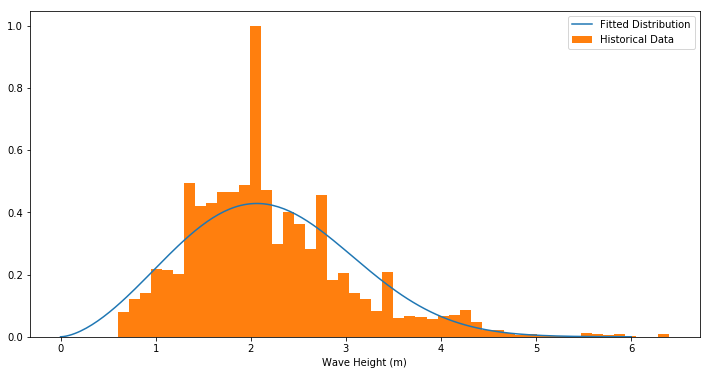

In [134]:
with model:
    x = np.linspace(0, 6, 200)
    #pdf = stats.gamma.pdf(x, trace['alpha'].mean(), scale=1.0/trace['beta'].mean())
    rv = stats.weibull_min(trace['alpha'].mean(), scale=trace['beta'].mean())
    pdf = rv.pdf(x)
    _, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x,pdf, label='Fitted Distribution')
    ax.hist(jan_feb_window_averages['AN_Wave_Height'], bins=50, density=True, label='Historical Data')
    ax.set_xlabel('Wave Height (m)')
    ax.legend()
    _.savefig('/Users/christopherberglund/Projects/stranding/monte_carlo_distribution.png')
#pdf
#trace['alpha'].mean()

In [135]:
pm.gelman_rubin(trace)

{'alpha': 1.000017145943725, 'beta': 0.9999764736700373}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121645400>,
      dtype=object)

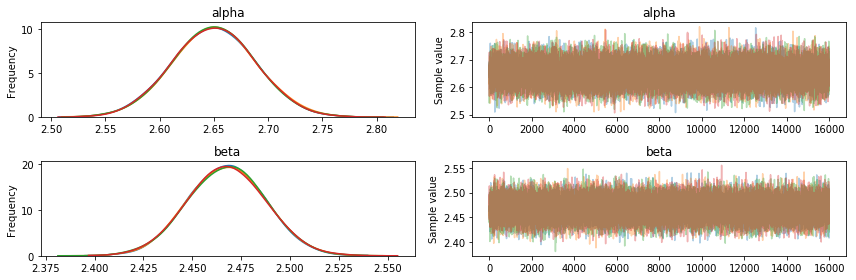

In [136]:
pm.traceplot(trace)

In [137]:
with model: 
    ppc = pm.sample_ppc(trace, size=18, model=model)

100%|██████████| 16000/16000 [01:07<00:00, 235.41it/s]


In [138]:
strandings = get_stranding_ano_wvht(time_lag)
strandings = strandings[(strandings['Stranding_County'].isin(['Santa Cruz', 'San Mateo'])) & (strandings['Strand_Date'].dt.dayofyear < 46)]

In [169]:
greater_than_sample = 0
with model:
    for index, row in strandings.iterrows():
        for sample in ppc['WVHT']:
            animal = sample[np.random.randint(0, len(sample)-1)]
            wvht = np.random.choice(animal)
            if row['AN_Wave_Height'] > wvht:
                greater_than_sample += 1
                
greater_than_sample/(len(strandings)*len(ppc['WVHT']))

0.6246654411764706

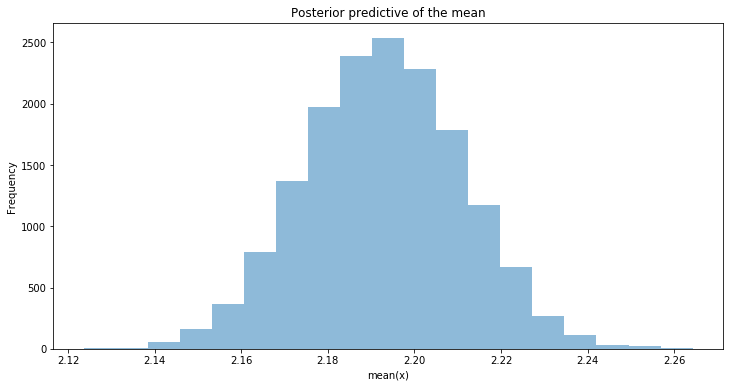

In [163]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['WVHT']], bins=19, alpha=0.5)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
_.savefig('/Users/christopherberglund/Projects/stranding/ppc_means.png')

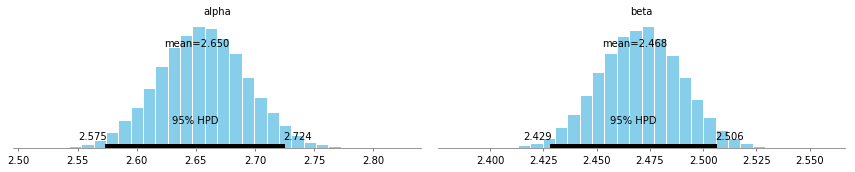

In [170]:
with model:
    pm.plot_posterior(trace)

### Weaners and Pups 2016-2018

In [290]:
averages = get_window_averages(24)
strandings = get_stranding_history(36)
averages = averages.groupby('Validity_Date').mean().reset_index()

In [17]:
import pymc3 as pm

with pm.Model() as weaner_model:
    alpha = pm.HalfNormal('alpha', sd=10)
    beta = pm.HalfNormal('beta', sd=10)
    Wave_obs = pm.Weibull('WVHT', alpha, beta, observed=averages['Wave_Height'])
    db = pm.backends.Text('/Users/christopherberglund/Projects/stranding/')
    trace = pm.sample(3000, tune=1000, trace=db)

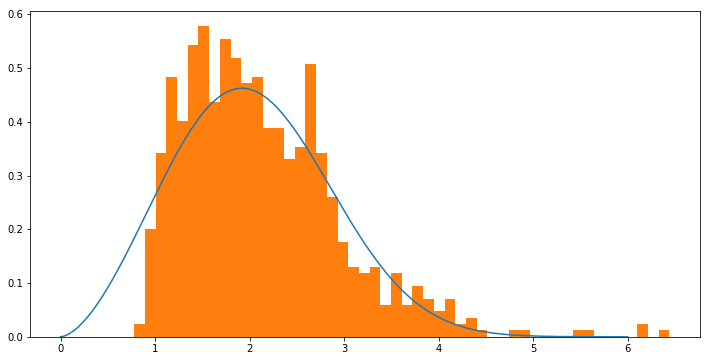

In [192]:
import scipy.stats as stats
with weaner_model:
    x = np.linspace(0, 6, 200)
    pdf = stats.gamma.pdf(x, trace['alpha'].mean(), scale=1.0/trace['beta'].mean())
    rv = stats.weibull_min(trace['alpha'].mean(), scale=trace['beta'].mean())
    pdf = rv.pdf(x)
    _, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x,pdf)
    ax.hist(averages[averages['Validity_Date'].dt.month.isin([1,2,3])]['Wave_Height'], bins=50, density=True)

(array([ 6.,  6.,  9., 17.,  9., 13., 16., 17., 15., 18.,  9., 11., 18.,
        14., 21., 13., 39., 12., 15.,  6.,  3.,  5.,  2.,  0.,  0.,  2.,
         0.,  0.,  1.,  3.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.7  , 0.796, 0.892, 0.988, 1.084, 1.18 , 1.276, 1.372, 1.468,
        1.564, 1.66 , 1.756, 1.852, 1.948, 2.044, 2.14 , 2.236, 2.332,
        2.428, 2.524, 2.62 , 2.716, 2.812, 2.908, 3.004, 3.1  , 3.196,
        3.292, 3.388, 3.484, 3.58 , 3.676, 3.772, 3.868, 3.964, 4.06 ,
        4.156, 4.252, 4.348, 4.444, 4.54 , 4.636, 4.732, 4.828, 4.924,
        5.02 , 5.116, 5.212, 5.308, 5.404, 5.5  ]),
 <a list of 50 Patch objects>)

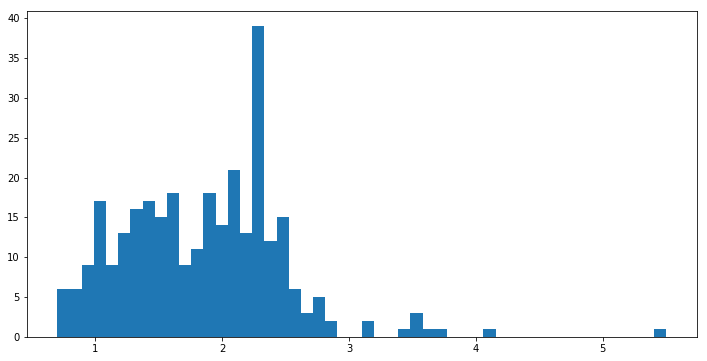

In [193]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist(strandings['Wave_Height'], bins=50)

In [78]:
with weaner_model: 
    ppc = pm.sample_ppc(trace, size=304, model=weaner_model)




  0%|          | 0/3000 [00:00<?, ?it/s]


  0%|          | 1/3000 [00:00<05:48,  8.60it/s]


  0%|          | 5/3000 [00:00<04:29, 11.13it/s]


  0%|          | 9/3000 [00:00<03:33, 14.00it/s]


  0%|          | 13/3000 [00:00<02:54, 17.13it/s]


  1%|          | 17/3000 [00:00<02:25, 20.46it/s]


  1%|          | 21/3000 [00:00<02:06, 23.63it/s]


  1%|          | 25/3000 [00:00<01:52, 26.42it/s]


  1%|          | 29/3000 [00:00<01:43, 28.79it/s]


  1%|          | 33/3000 [00:00<01:36, 30.74it/s]


  1%|          | 37/3000 [00:01<01:32, 32.02it/s]


  1%|▏         | 41/3000 [00:01<01:32, 32.14it/s]


  2%|▏         | 45/3000 [00:01<01:30, 32.63it/s]


  2%|▏         | 49/3000 [00:01<01:28, 33.47it/s]


  2%|▏         | 53/3000 [00:01<01:25, 34.38it/s]


  2%|▏         | 57/3000 [00:01<01:23, 35.12it/s]


  2%|▏         | 61/3000 [00:01<01:22, 35.52it/s]


  2%|▏         | 65/3000 [00:01<01:24, 34.92it/s]


  2%|▏         | 69/3000 [00:02<01:25, 34.31it/s]


  2%|▏         | 73/3

In [280]:
strandings = get_stranding_history(24)

In [283]:
a = averages[averages['Validity_Date'].dt.month < 3]
a['Wave_Height'].mean()

2.213012239570508

In [282]:
t = strandings[strandings['Stranding_Date'].dt.month < 3]
t['Wave_Height'].mean()

2.375

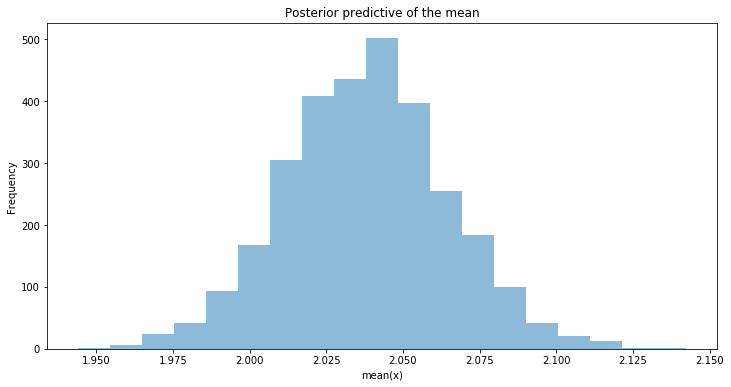

In [269]:
with weaner_model:
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist([n.mean() for n in ppc['WVHT']], bins=19, alpha=0.5)
    #ax.axvline(data.mean())
    ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

<BarContainer object of 121 artists>

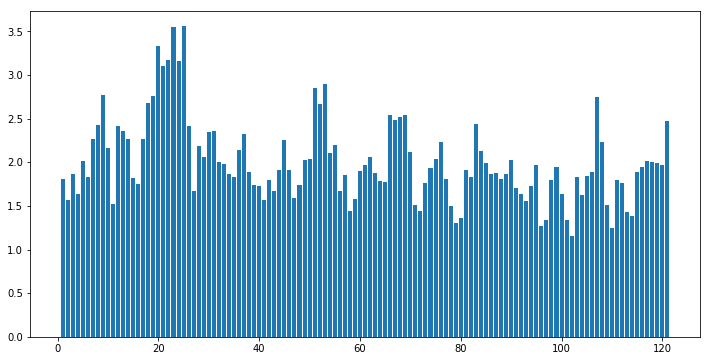

In [219]:
_, ax = plt.subplots(figsize=(12, 6))
means = averages.groupby(averages['Validity_Date'].dt.dayofyear).mean().reset_index()

ax.bar(means['Validity_Date'], means['Wave_Height'])

In [261]:
df = pd.DataFrame(columns=['STAR_ID', 'Wave_Height', 'Greater_Than_Sample'])

stranding_comparisons = []
observed_wvht = strandings['Wave_Height'].mean()
greater_than_sample =0
with weaner_model:
    for sample in ppc['WVHT']:
        wvhts = []
        for animal in samples:
            wvht = np.random.choice(animal)
            wvhts.append(wvht)
        print(np.mean(animal))
        if observed_wvht > np.mean(wvhts):
            greater_than_sample = greater_than_sample + 1

2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710113976
2.0561219710

In [259]:
greater_than_sample

0

(array([ 19., 103.,  86.,  38.,  36.,  13.,   7.,   0.,   0.,   2.]),
 array([0.7, 1.2, 1.7, 2.2, 2.7, 3.2, 3.7, 4.2, 4.7, 5.2, 5.7]),
 <a list of 10 Patch objects>)

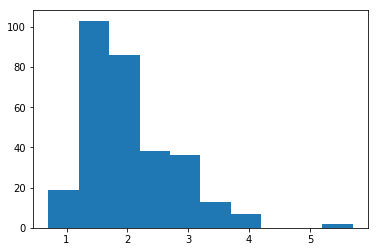

In [33]:
import seaborn as sns
df = get_stranding_history(36)
plt.figure()
plt.hist(df['AN_Wave_Height'])
#plt.suptitle('Wave Height at Stranding Site Prior to Strand')
#f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18,9))
#sns.regplot(x='Value', y='Frequency', data=get_stranding_frequency(6), ax=ax1)
#sns.regplot(x='Value', y='Frequency', data=get_stranding_frequency(12), ax=ax2)
#sns.regplot(x='Value', y='Frequency', data=get_stranding_frequency(18), ax=ax3)
#sns.regplot(x='Value', y='Frequency', data=get_stranding_frequency(24), ax=ax4)
#sns.regplot(x='Value', y='Frequency', data=get_stranding_frequency(30), ax=ax5)
#sns.regplot(x='Value', y='Frequency', data=get_stranding_frequency(36), ax=ax6)

In [28]:
from scipy import stats
 

df = get_stranding_history(36)
df2 = get_ano_nuevo_window(36)
df3 = get_window_averages(36)
df2 = df2[df2['Validity_Date'].dt.month.isin([1,2,3,4])]
df3 = df3[df3['Validity_Date'].dt.month.isin([1,2,3,4])]
F, p = stats.f_oneway(df['Wave_Height'], df3['Wave_Height'])

<Figure size 432x288 with 0 Axes>

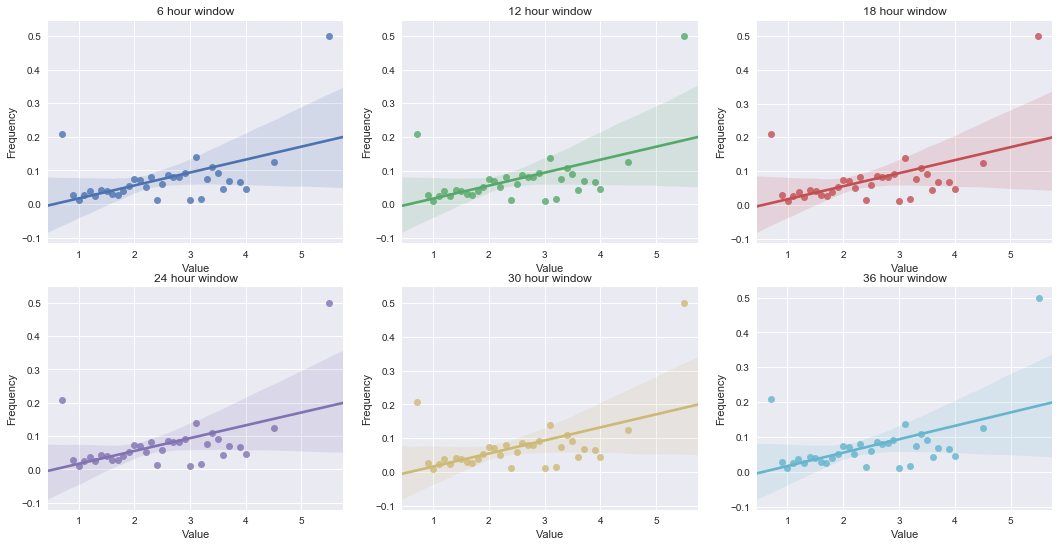

In [932]:
import seaborn as sns
sns.set()
freq = get_stranding_frequency(24)
plt.suptitle('Wave Height at Ano Nuevo Prior to Strand')
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18,9))
sns.regplot(x='Value', y='Frequency', data=get_rookerie_frequency(6), ax=ax1)
sns.regplot(x='Value', y='Frequency', data=get_rookerie_frequency(12), ax=ax2)
sns.regplot(x='Value', y='Frequency', data=get_rookerie_frequency(18), ax=ax3)
sns.regplot(x='Value', y='Frequency', data=get_rookerie_frequency(24), ax=ax4)
sns.regplot(x='Value', y='Frequency', data=get_rookerie_frequency(30), ax=ax5)
sns.regplot(x='Value', y='Frequency', data=get_rookerie_frequency(36), ax=ax6)
ax1.set_title('6 hour window')
ax2.set_title('12 hour window')
ax3.set_title('18 hour window')
ax4.set_title('24 hour window')
ax5.set_title('30 hour window')
ax6.set_title('36 hour window')
f.savefig('/Users/christopherberglund/Projects/stranding/graphic2.png')

In [37]:
df = pd.read_csv('/Users/christopherberglund/Projects/stranding/ndfd_local_data.csv')
df = df.drop_duplicates(['Latitude', 'Longitude', 'Validity_Date'])
df

,Data_Date,Validity_Date,Latitude,Longitude,WVHT_Latitude,WVHT_Longitude,STAR_ID,Wave_Height,Wind_Direction,Wind_Speed,Prcp
0,2017-08-25 05:00:00,2017-08-25 06:00:00,29.2602,-123.1256,29.2602,-123.1256,S-16-001218,1.5,340.0,8.2,0.0
4,2017-08-25 05:00:00,2017-08-25 06:00:00,35.3727,-120.8672,35.3727,-120.8672,S-16-000110,1.8,310.0,4.1,0.0
5,2017-08-25 05:00:00,2017-08-25 06:00:00,36.4388,-121.9165,36.4388,-121.9165,S-17-000510,2.1,0.0,7.2,0.0
7,2017-08-25 05:00:00,2017-08-25 06:00:00,36.4826,-121.9274,36.4738,-121.9820,S-17-000963,2.1,0.0,5.7,0.0
8,2017-08-25 05:00:00,2017-08-25 06:00:00,36.5703,-121.9494,36.5265,-121.9384,S-16-000532,1.8,320.0,4.6,0.0
9,2017-08-25 05:00:00,2017-08-25 06:00:00,36.5265,-121.9384,36.5265,-121.9384,S-16-000535,1.8,330.0,3.6,0.0
27,2017-08-25 05:00:00,2017-08-25 06:00:00,36.6141,-121.9604,36.6141,-121.9604,S-16-000584,1.8,310.0,6.2,0.0
28,2017-08-25 05:00:00,2017-08-25 06:00:00,36.6230,-121.9058,36.6141,-121.9604,S-16-000720,1.8,300.0,4.6,0.0
61,2017-08-25 05:00:00,2017-08-25 06:00:00,36.5879,-121.8402,36.6318,-121.8512,S-16-001426,1.8,250.0,2.6,0.0
67,2017-08-25 05:00:00,2017-08-25 06:00:00,36.6318,-121.8512,36.6318,-121.8512,S-17-000530,1.8,270.0,4.1,0.0


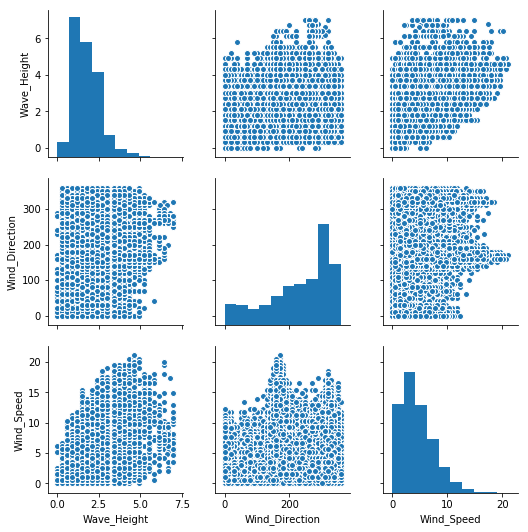

In [14]:
import seaborn as sns

f = sns.pairplot(df[['Wave_Height', 'Wind_Direction', 'Wind_Speed']], size=2.5);
f.savefig('/Users/christopherberglund/Projects/stranding/pair_plots.png')

In [44]:
df = get_window_averages(24)
df

,Latitude,Longitude,STAR_ID,Validity_Date,Wave_Height,Wind_Speed,Wind_Direction,Prcp,Validity_Date2,WDSPD_Frequency
0,36.5703,-121.9494,S-16-000532,2016-01-01 06:00:00,0.9,4.6,60.0,0.0,2016-01-02 06:00:00,1429
111074,37.5665,-122.5463,S-16-001726,2016-01-01 06:00:00,1.1,4.9,70.4,0.0,2016-01-02 06:00:00,243
78180,36.6230,-121.9058,S-18-000633,2016-01-01 06:00:00,1.0,4.1,77.1,0.0,2016-01-02 06:00:00,2724
111317,37.5755,-122.4912,S-17-001214,2016-01-01 06:00:00,1.1,5.0,70.4,0.0,2016-01-02 06:00:00,1095
111318,37.5755,-122.4912,S-18-000650,2016-01-01 06:00:00,1.1,5.0,70.4,0.0,2016-01-02 06:00:00,1095
111319,37.5755,-122.4912,S-18-000738,2016-01-01 06:00:00,1.1,5.0,70.4,0.0,2016-01-02 06:00:00,1095
57729,36.5265,-121.9384,S-17-000654,2016-01-01 06:00:00,0.9,4.0,85.9,0.0,2016-01-02 06:00:00,3229
111073,37.5665,-122.5463,S-16-000997,2016-01-01 06:00:00,1.1,4.9,70.5,0.0,2016-01-02 06:00:00,243
57730,36.5265,-121.9384,S-17-000834,2016-01-01 06:00:00,0.9,4.0,85.5,0.0,2016-01-02 06:00:00,3229
57732,36.5265,-121.9384,S-18-000696,2016-01-01 06:00:00,0.9,4.0,84.9,0.0,2016-01-02 06:00:00,3229


In [15]:
import statsmodels.api as sm
X = df
model = sm.OLS(X['Wind_Speed'], X['Wave_Height']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Wind_Speed   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                 2.833e+05
Date:                Wed, 26 Sep 2018   Prob (F-statistic):               0.00
Time:                        11:27:34   Log-Likelihood:            -2.4038e+05
No. Observations:               98190   AIC:                         4.808e+05
Df Residuals:                   98189   BIC:                         4.808e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Wave_Height     2.4662      0.005    532.296      0.000       2.457       2.475
==============================================================================
Omnibus:                      851.171   Durbin-Watson:                   0.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1326.403
Skew:                          -0.063   Prob(JB):                    9.45e-289
Kurtosis:                       3.555   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
def get_window_averages(time_lag):
    df = pd.read_csv('/Users/christopherberglund/Projects/stranding/ndfd_local_data.csv', float_precision='high') 
    df = df.drop_duplicates(['Latitude', 'Longitude', 'Validity_Date'])
    df['Validity_Date'] = pd.to_datetime(df['Validity_Date'])
    averages = df[['Validity_Date','Wave_Height', 'Wind_Speed', 'Wind_Direction', 'Prcp']].rolling(str(time_lag)+'h', on='Validity_Date').mean()
    averages['Validity_Date'] = averages['Validity_Date'] + pd.Timedelta(str(time_lag) + 'h')
    #averages['Validity_Date'] = pd.to_datetime(averages['Validity_Date'])
    #averages = averages.rename(columns={'validityDate': 'Validity_Date'})
    averages['Validity_Date2'] = averages['Validity_Date']
    #averages['Value'] = averages['Value'].round(1)
    
    freq = (averages.groupby('Value')
            .count()
            .rename(columns={'Validity_Date': 'Frequency'})
            .drop('Validity_Date2', axis=1)
            .reset_index())
    averages = pd.merge(left=averages, right=freq, on='Value').sort_values('Validity_Date')
    return averages

In [24]:
wvht = pd.read_csv('/Users/christopherberglund/Projects/stranding/ndfd_data_formatted.csv', float_precision='high') 
wvht['validityDate'] = pd.to_datetime(wvht['validityDate'])
wvht = wvht.iloc[wvht.groupby('validityDate')['delDataValidity'].idxmin()]
wvht

FileNotFoundError: File b'/Users/christopherberglund/Projects/stranding/ndfd_data_formatted.csv' does not exist